In [1]:
import random
import math
import time
import matplotlib.pyplot as plt

In [2]:
def decide_turn(x, y, vx, vy):
     
    if x == 0 and y == 0 and vx == -1:
        vx = 0
        vy = 1
    elif x == 0 and y == 0 and vy == -1:
        vx = 1
        vy = 0
    elif x == 3000 and y == 0 and vx == 1:
        vx = 0
        vy = 1
    elif x == 3000 and y == 0 and vy == -1:
        vx = -1
        vy = 0
    elif x == 0 and y == 3000 and vx == -1:
        vx = 0
        vy = -1
    elif x == 0 and y == 3000 and vy == 1:
        vx = 1
        vy = 0
    elif x == 3000 and y == 3000 and vx == 1:
        vx = 0
        vy = -1
    elif x == 3000 and y == 3000 and vy == 1:
        vx = -1
        vy = 0
    else:
        p = random.random()
        if p >= 0.5:
            return vx, vy
        elif p >= 1/3 and p < 0.5:
            if vx == 1 and vy == 0:
                vx = 0
                vy = -1
            elif vx == 0 and vy == 1:
                vx = 1
                vy = 0
            elif vx == -1 and vy == 0:
                vx = 0
                vy = 1
            else:
                vx = -1
                vy = 0          
        else:
            if vx == 1 and vy == 0:
                vx = 0
                vy = 1
            elif vx == 0 and vy == 1:
                vx = -1
                vy = 0
            elif vx == -1 and vy == 0:
                vx = 0
                vy = -1
            else:
                vx = 1
                vy = 0   
    
    return vx, vy
        

In [3]:
def create_car(x, y, vx, vy, bs):
    global n
    if(random.random() > P):
        return
    
    vx, vy = decide_turn(x, y, vx, vy)
    
    
    cars.append((x, y, vx, vy, bs, bs, bs, bs))
    
    n = n + 1




In [4]:
def cal_power(d):
    if d == 0:
        temp = -60
    else:
        temp = (-60 - 20*math.log10(d))
        
    return temp


In [6]:
E = 5
T = -110
Pt = -50
Pmin = -125
v_car = 10
P = (2 / 60) * math.exp(-(2 / 60))
road_len = 750
BS = ((750, 750), (2250, 750), (750, 2250), (2250, 2250))
cars = []
n = 0
handoff = 4*[0]
Y = [[], [], [], []]
P_int1 = cal_power(750)
P_int2 = cal_power(750*(2**(1/2)))

print(time.asctime(time.localtime(time.time())))

# create_car(road_len, 0, 0, 1, 0, P_int1) # create cars
for i in range(86400):
    leave_cars = []
    
    if i % 10000 == 0:
        print(handoff)
        
    create_car(road_len, 0, 0, 1, 0) # create cars
    create_car(road_len*2, 0, 0, 1, 0)
    create_car(road_len*3, 0, 0, 1, 1)
    create_car(0, road_len, 1, 0, 0)
    create_car(0, road_len*2, 1, 0, 0)
    create_car(0, road_len*3, 1, 0, 2)
    create_car(road_len, road_len*4, 0, -1, 2)
    create_car(road_len*2, road_len*4, 0, -1, 2)
    create_car(road_len*3, road_len*4, 0, -1, 3)
    create_car(road_len*4, road_len, -1, 0, 1)
    create_car(road_len*4, road_len*2, -1, 0, 1)
    create_car(road_len*4, road_len*3, -1, 0, 3)
    
    for id in range(len(cars)): # moving car
        attr = cars[id] 
        x = attr[0] + v_car*attr[2]
        y = attr[1] + v_car*attr[3]
        vx = attr[2]
        vy = attr[3]
        policy1 = attr[4]
        policy2 = attr[5]
        policy3 = attr[6]
        policy4 = attr[7]
        
        # car leaving
        if x > 3000 or x < 0 or y > 3000 or y < 0: 
            leave_cars.append(id)
            continue
            
        # car turning
        if x%750 == 0 and y%750 == 0: 
            vx, vy = decide_turn(x, y, vx, vy)
            
        P_new = -1000
        P_old = 4*[-1000]
        BS_max = -1
        for j in range(4):
            d = ((x-BS[j][0])**2 + (y-BS[j][1])**2)**(1/2)
            P_temp = cal_power(d)
            if j == policy1:
                P_old[0] = P_temp   
            if j == policy2:
                P_old[1] = P_temp   
            if j == policy3:
                P_old[2] = P_temp   
            if j == policy4:
                P_old[3] = P_temp   
                
            if P_temp > P_new:
                P_new = P_temp
                BS_max = j

        # policy 1
        if BS_max != policy1 and P_new > P_old[0]:
            handoff[0] = handoff[0] + 1
            policy1 = BS_max


                 
        # policy 2
        if BS_max != policy2 and P_new > P_old[1] and P_old[1] < T:
            handoff[1] = handoff[1] + 1
            policy2 = BS_max

                
        # policy 3
        if BS_max != policy3 and P_new > P_old[2] + E:
            handoff[2] = handoff[2] + 1
            policy3 = BS_max
                
        # policy 4
        if BS_max != policy4 and P_new > P_old[3] and P_old[3] < Pmin:
            handoff[3] = handoff[3] + 1
            policy4 = BS_max
    
        cars[id] = (x, y, vx, vy, policy1, policy2, policy3, policy4)
    
    leave_cars.sort(reverse=True)
    for id in leave_cars: # leaving car
        del cars[id]
        
    for k in range(4):
        Y[k].append(handoff[k])
        

print(handoff)
print(time.asctime(time.localtime(time.time())))
    
    
        
    
    

Fri Nov 15 21:46:02 2019
[0, 0, 0, 0]
[4627, 4627, 4617, 2796]
[9421, 9421, 9404, 5698]
[14259, 14259, 14240, 8669]
[19099, 19099, 19075, 11574]
[23951, 23951, 23934, 14541]
[28714, 28714, 28701, 17364]
[33389, 33389, 33376, 20217]
[37955, 37955, 37942, 22979]
[40991, 40991, 40975, 24797]
Fri Nov 15 21:49:57 2019


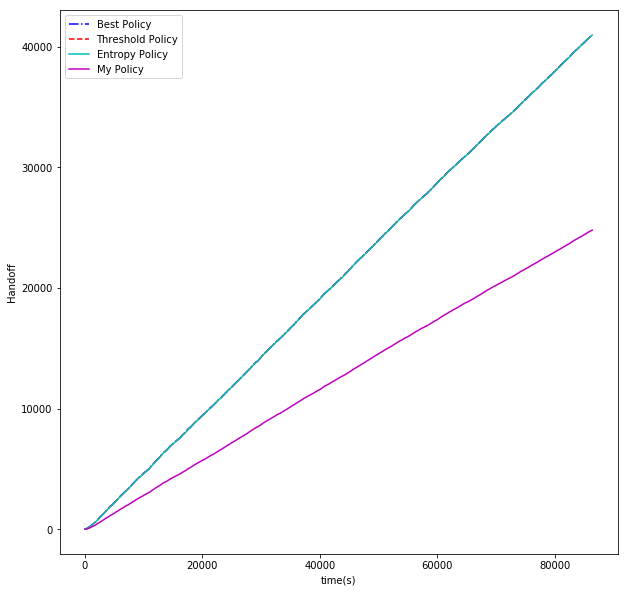

In [47]:
X = list(range(86400))

plt.figure(1, figsize=(50, 50))
plt.plot(X, Y[0], 'b-.', label='Best Policy')
plt.plot(X, Y[1], 'r--', label='Threshold Policy')
plt.plot(X, Y[2], 'c', label='Entropy Policy')
plt.plot(X, Y[3], 'm', label='My Policy')
plt.xlabel('time(s)')
plt.ylabel('Handoff')
plt.legend()
plt.show()

In [27]:
Y[3][40000]

11574

In [9]:
print(len(cars))
print(n)


180
33473


In [4]:
a = 5
b = 'dfdf'

print('Policy{}: {}'.format(a, b))

Policy5: dfdf
